# Activity Prediction

Thirty volunteers engaged in 12 different physical activities:

1 WALKING  
2 WALKING_UPSTAIRS  
3 WALKING_DOWNSTAIRS  
4 SITTING  
5 STANDING  
6 LAYING  
7 STAND_TO_SIT  
8 SIT_TO_STAND  
9 SIT_TO_LIE  
10 LIE_TO_SIT  
11 STAND_TO_LIE  
12 LIE_TO_STAND  

They each were wearing a smartphone, which captured movement data via the embedded accelerometer and gyroscope. The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2), normalized to a scale of -1 to 1.  
  
Below, a subset of the collected data was used to attempt to classify what movement the volunteers made. A random forest classifier was the tool of choice, as there were a large number of variables.

A more thorough description of the experiment and dataset can be found here:  
http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation as cv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

Step 1: Read in the data for the training table, filtered for 'Mag' and 'Angle' variables, and add 'subject' and 'activity' columns. This gives us 124 columns of variables, plus a column showing which volunteer made the action and a column showing what action was made.

In [2]:
features = [line.strip() for line in open('HAPT_Data_Set/features.txt','r')]
sub_features = [(features.index(s), s) for s in features if ('Mag' in s) or ('Angle' in s)]
sub_features_indices = [i[0] for i in sub_features]
sub_features_names = [i[1] for i in sub_features]
df = pd.read_table('HAPT_Data_Set/Train/X_train.txt', delimiter=' ',
                       usecols=sub_features_indices, names=sub_features_names)
subjects = [line.strip() for line in open('HAPT_Data_Set/Train/subject_id_train.txt','r')]
df['subject'] = subjects
activity = [line.strip() for line in open('HAPT_Data_Set/Train/y_train.txt','r')]
df['activity'] = activity
df.head()

,tBodyAccMag-Mean-1,tBodyAccMag-STD-1,tBodyAccMag-Mad-1,tBodyAccMag-Max-1,tBodyAccMag-Min-1,tBodyAccMag-SMA-1,tBodyAccMag-Energy-1,tBodyAccMag-IQR-1,tBodyAccMag-ropy-1,tBodyAccMag-ARCoeff-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,activity
0,-0.969546,-0.961540,-0.967646,-0.947236,-0.994174,-0.969546,-0.999150,-0.970525,-0.219620,-0.124072,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,5
1,-0.984484,-0.981042,-0.983105,-0.979658,-0.996348,-0.984484,-0.999709,-0.986893,-0.426713,0.129618,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,5
2,-0.987805,-0.990189,-0.990798,-0.987446,-0.996348,-0.987805,-0.999818,-0.990025,-0.583114,0.086279,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,5
3,-0.989940,-0.988966,-0.989351,-0.987446,-0.997687,-0.989940,-0.999849,-0.988460,-0.572296,-0.044082,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,5
4,-0.994669,-0.992678,-0.992968,-0.991914,-0.997687,-0.994669,-0.999929,-0.992688,-0.686673,0.228080,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,5


In [3]:
df.describe()

,tBodyAccMag-Mean-1,tBodyAccMag-STD-1,tBodyAccMag-Mad-1,tBodyAccMag-Max-1,tBodyAccMag-Min-1,tBodyAccMag-SMA-1,tBodyAccMag-Energy-1,tBodyAccMag-IQR-1,tBodyAccMag-ropy-1,tBodyAccMag-ARCoeff-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
count,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,...,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000
mean,-0.627607,-0.654652,-0.693659,-0.532244,-0.864681,-0.627607,-0.851118,-0.758387,0.166886,-0.045359,...,0.161745,-0.316548,-0.625132,0.016774,0.018471,0.009239,-0.005184,-0.485936,0.050310,-0.052888
std,0.381838,0.360414,0.325759,0.474890,0.174854,0.381838,0.198031,0.274643,0.666728,0.302973,...,0.237319,0.313899,0.302581,0.331326,0.443540,0.601208,0.477218,0.509278,0.300866,0.276196
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.958535,-1.000000,-1.000000,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.987874
25%,-0.986273,-0.985412,-0.987202,-0.980871,-0.994161,-0.986273,-0.999761,-0.988963,-0.525887,-0.273569,...,0.020312,-0.548129,-0.843966,-0.108225,-0.261002,-0.470267,-0.373565,-0.810953,-0.047752,-0.140560
50%,-0.845111,-0.794509,-0.808414,-0.748429,-0.965850,-0.845111,-0.982626,-0.850536,0.331897,-0.048423,...,0.170819,-0.353980,-0.710071,0.017627,0.029079,0.001515,-0.005503,-0.706619,0.176777,0.004583
75%,-0.304371,-0.386994,-0.461897,-0.130424,-0.758163,-0.304371,-0.749931,-0.589297,0.814124,0.171563,...,0.316240,-0.137462,-0.503837,0.167695,0.314876,0.496871,0.352690,-0.488765,0.246834,0.109507
max,1.000000,0.928437,0.908050,1.000000,1.000000,1.000000,1.000000,0.961572,1.000000,1.000000,...,1.000000,0.938491,0.911653,1.000000,1.000000,0.998702,0.991288,1.000000,0.482229,1.000000


Step 2: Follow the same process for the testing table.

In [4]:
df_test = pd.read_table('HAPT_Data_Set/Test/X_test.txt', delimiter=' ',
                       usecols=sub_features_indices, names=sub_features_names)
subjects_test = [line.strip() for line in open('HAPT_Data_Set/Test/subject_id_test.txt','r')]
df_test['subject'] = subjects_test
activity_test = [line.strip() for line in open('HAPT_Data_Set/Test/y_test.txt','r')]
df_test['activity'] = activity_test

Step 3: Exploratory Data Analysis (EDA): Choose one variable, and create histograms for the 12 activities to evaluate the ability of this particular variable to predict static vs dynamic activities.

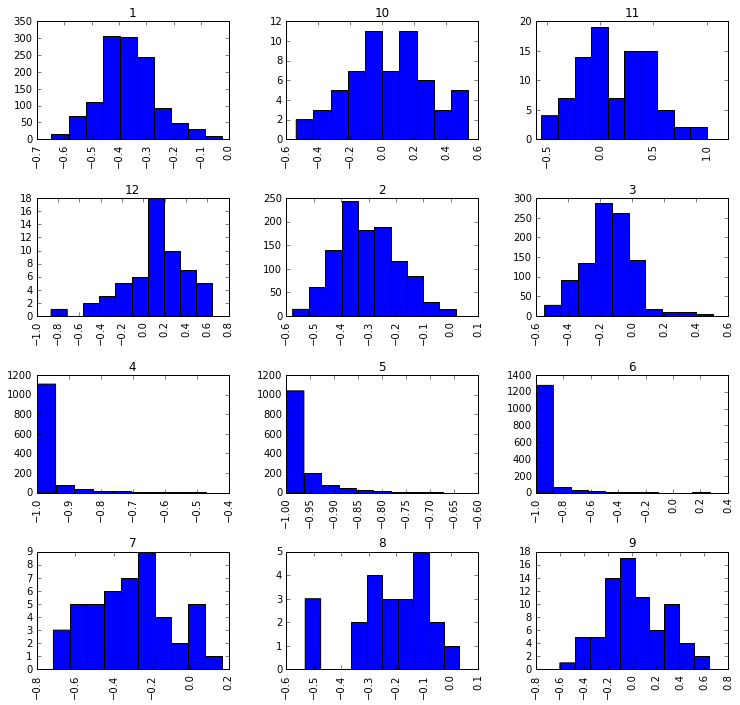

In [5]:
df['tBodyAccMag-Mean-1'].hist(by=df['activity'],figsize=(12,12));

Activities 4, 5, and 6 (sitting, standing, and laying) are the three static activities out of the 12 and show a very different distribution of units to the other 9 activities. They are also very similar in their distributions, which may render this variable largely ineffective in predicting these three activities. Also worth noting: Activities 7-12 have fairly low volumes compared to the rest.

Step 4: Split the initial training table into training and validation sets, and fit a random forest classifier using 500 estimators to the training set.

In [6]:
X = df[df.columns.tolist()[:-1]]
y = df['activity']

X_train, X_val, y_train, y_val = cv.train_test_split(X, y, train_size=0.8, random_state=0)
clf = RandomForestClassifier(n_estimators=500, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Step 5: Rank the features by importance scores, and single out the top 10 features.

In [7]:
importance_scores = clf.feature_importances_.tolist()
important_features = list(zip(df.columns.tolist()[:-1], importance_scores))
important_features.sort(key=lambda x: x[1], reverse=True)
top_10_features = important_features[:10]
top_10_features

[('tXAxisAcc-AngleWRTGravity-1', 0.11828104827409373),
 ('tYAxisAcc-AngleWRTGravity-1', 0.10603319473553538),
 ('tZAxisAcc-AngleWRTGravity-1', 0.05711410414047458),
 ('tBodyAccJerkMag-IQR-1', 0.021075517754184155),
 ('tBodyAccJerkMag-Mean-1', 0.020576027789454904),
 ('tBodyAccJerkMag-SMA-1', 0.02007105804645482),
 ('tBodyAccJerkMag-Energy-1', 0.01919439062295633),
 ('fBodyAccMag-STD-1', 0.016349581436512047),
 ('tBodyAccJerkMag-ropy-1', 0.01555544096871922),
 ('tBodyGyroJerkMag-Mean-1', 0.015509956939020103)]

Step 6: Identify the model's accuracy score on the validation set.

In [8]:
predicted_from_val = clf.predict(X_val)
expected_from_val = y_val

metrics.accuracy_score(expected_from_val, predicted_from_val)

0.94465894465894462

Step 7: Identify the model's overall accuracy and OOB scores.

In [9]:
predicted_from_test = clf.predict(df_test[df_test.columns.tolist()[:-1]])
expected_from_test = df_test['activity']

metrics.accuracy_score(expected_from_test, predicted_from_test)

0.87539531941808979

In [10]:
clf.oob_score_

0.93915982617093197

Step 8: Identify precision, recall, and F1 scores on the individual activities from the test set. Print out a confusion matrix on the test set as well.

In [11]:
df_metrics = pd.DataFrame({'activity':range(1,13),
                           'precision':metrics.precision_score(expected_from_test, predicted_from_test, average=None),
                           'recall':metrics.recall_score(expected_from_test, predicted_from_test, average=None),
                           'f1':metrics.f1_score(expected_from_test, predicted_from_test, average=None)})
df_metrics

,activity,f1,precision,recall
0,1,0.899354,0.829642,0.981855
1,2,0.654545,0.600000,0.720000
2,3,0.505495,0.547619,0.469388
3,4,0.358974,0.583333,0.259259
4,5,0.831389,0.830508,0.832272
5,6,0.864230,0.956647,0.788095
6,7,0.859487,0.897216,0.824803
7,8,0.885813,0.853333,0.920863
8,9,0.997245,0.998162,0.996330
9,10,0.512821,0.625000,0.434783


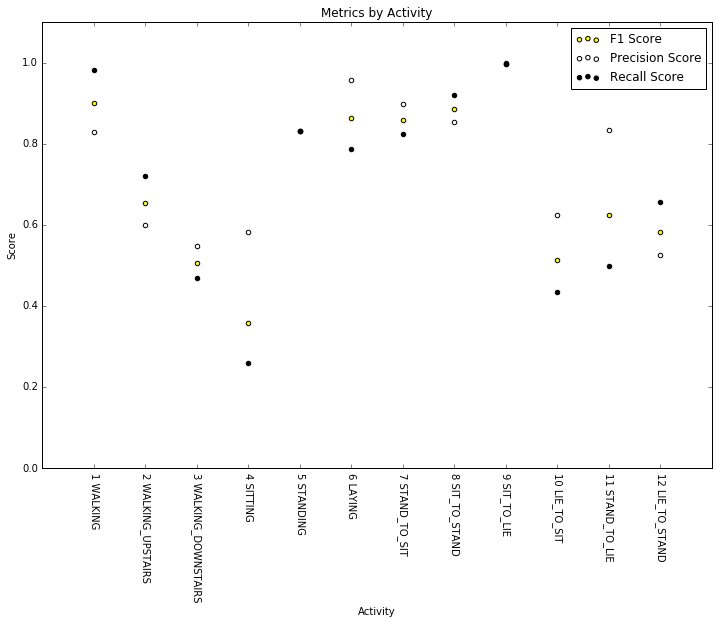

In [12]:
ax = df_metrics.plot(kind='scatter', x='activity', y='f1',
                     c='Yellow', label='F1 Score', figsize=(12, 8))
df_metrics.plot(kind='scatter', x='activity', y='precision',
                c='White', label='Precision Score', ax=ax)
df_metrics.plot(kind='scatter', x='activity', y='recall',
                c='Black', label='Recall Score', ax=ax)
plt.title('Metrics by Activity')
plt.xlabel('Activity')
plt.ylabel('Score')
plt.axis([0,13,0,1.1])
plt.xticks(np.arange(13),
           ['']+[line.strip() for line in open('HAPT_Data_Set/activity_labels.txt','r')],
           rotation=270);

In [13]:
metrics.confusion_matrix(predicted_from_test, expected_from_test)

array([[487,   0,   2,   1,  71,  26,   0,   0,   0,   0,   0,   0],
       [  0,  18,   0,  11,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   1,  23,   5,   0,   0,   0,   0,   0,   3,   1,   9],
       [  0,   4,   1,   7,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   1,   6,   0, 392,  63,   0,   0,   1,   5,   0,   1],
       [  6,   0,   0,   0,   8, 331,   0,   0,   0,   1,   0,   0],
       [  0,   0,   1,   0,   0,   0, 419,  43,   0,   3,   1,   0],
       [  0,   0,   0,   0,   0,   0,  88, 512,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0, 543,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   1,   1,   1,  10,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   5,   0],
       [  0,   1,  13,   3,   0,   0,   0,   0,   0,   0,   2,  21]])

Conclusion: The random forest classifier produced strong results on the test data set, as evidenced by the accuracy and OOB scores. Looking at precision and recall for each individual activity, scores are surprisingly high for activities 7-12 considering the low volume of records in the train set. Conversely, the model mistook several differrent actions for sitting, including all three walking activities, leading to a dismal accuracy score of .26. This result would warrant further investigation and perhaps the use of a different model with the end goal of achieving more consistent results across all activities, as the current results vary widely.